In [1]:
import numpy as np
import tensorflow as tf
import gpflow
from gpflow.config import default_float
from gpflow.utilities import print_summary
import matplotlib.pyplot as plt
from utils import plot
from celluloid import Camera
from functools import partial

In [2]:
tf.random.set_seed(293566)
num_train_data = 3
num_test_data = 100

X = tf.random.uniform((num_train_data, 1), dtype=default_float()) * 5
Y = tf.random.uniform((num_train_data, 1), dtype=default_float())

X_query = tf.linspace(0, 5, num_test_data)[:, None]

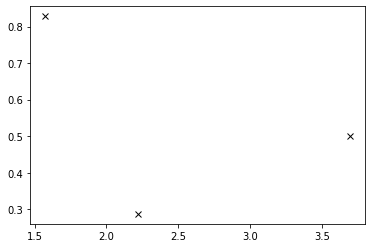

In [3]:
plt.plot(X, Y, "xk")
plt.show()

In [9]:
kernel = gpflow.kernels.SquaredExponential(lengthscales=0.5, variance=0.8)
Z = X

m = gpflow.models.SVGP(kernel=kernel, likelihood=gpflow.likelihoods.Gaussian(), inducing_variable=Z, num_data=num_train_data)
m.likelihood.variance.assign(0.01**2)
gpflow.set_trainable(m.kernel.variance, False)
gpflow.set_trainable(m.kernel.lengthscales, False)
gpflow.set_trainable(m.likelihood.variance, False)
gpflow.set_trainable(m.inducing_variable.Z, False)
print_summary(m)

╒══════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═══════════╤═════════╤════════════════════════╕
│ name                     │ class     │ transform        │ prior   │ trainable   │ shape     │ dtype   │ value                  │
╞══════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═══════════╪═════════╪════════════════════════╡
│ SVGP.kernel.variance     │ Parameter │ Softplus         │         │ False       │ ()        │ float64 │ 0.8000000000000002     │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────┼─────────┼────────────────────────┤
│ SVGP.kernel.lengthscales │ Parameter │ Softplus         │         │ False       │ ()        │ float64 │ 0.5                    │
├──────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼───────────┼─────────┼────────────────────────┤
│ SVGP.likelihood.variance │ Parameter │ Softplus + Shift │         │ False       │

In [10]:
minibatch_size = 3

train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)).repeat().shuffle(num_train_data)
train_iter = iter(train_dataset.batch(minibatch_size))
training_loss = m.training_loss_closure(train_iter, compile=True)
optimizer = tf.optimizers.Adam()

@tf.function
def optimization_step():
    optimizer.minimize(training_loss, m.trainable_variables)


In [11]:
def take_picture(gp, X_query, data, fig, camera, num_samples=5, seed=0, jitter=1e-9):
    mean, cov = gp.predict_f(X_query, full_cov=True)
    N, d = mean.shape
    var = tf.linalg.diag_part(cov)
    var = tf.reshape(var, (N, d))
    samples = []
    for _ in range(num_samples):
        tf.random.set_seed(seed)
        cho = tf.linalg.cholesky(cov[0] + jitter*tf.eye(N, dtype=tf.float64))
        noise = tf.random.normal(X_query.shape, dtype=default_float())
        samples.append(mean + cho@noise)
        seed += 1
    samples = tf.convert_to_tensor(samples)
    plot(X_query, mean, var, samples, data=data, fig=fig)
    plt.ylim(-2.3, 2.3)
    camera.snap()

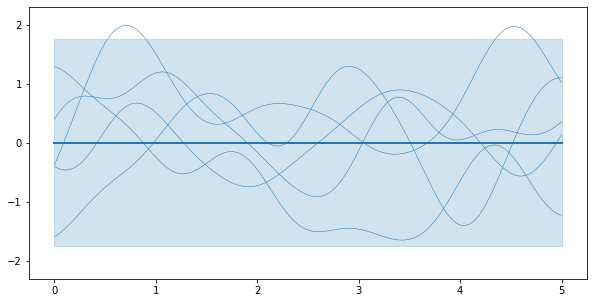

In [7]:
# Save figure of initial state
mean, cov = m.predict_f(X_query, full_cov=True)
jitter=1e-9
N, d = mean.shape
var = tf.linalg.diag_part(cov)
var = tf.reshape(var, (N, d))
samples = []
SEED = 0
for _ in range(5):
        tf.random.set_seed(SEED)
        cho = tf.linalg.cholesky(cov[0] + jitter*tf.eye(N, dtype=tf.float64))
        noise = tf.random.normal(X_query.shape, dtype=default_float())
        samples.append(mean + cho@noise)
        SEED += 1
samples = tf.convert_to_tensor(samples)
plot(X_query, mean, var, samples)
plt.ylim(-2.3, 2.3)
plt.savefig("figs/gp_state_before_training.png", dpi=200)

ELBO at step 0: -17045.07
ELBO at step 100: -13727.00
ELBO at step 200: -10155.54
ELBO at step 300: -8897.15
ELBO at step 400: -5980.49
ELBO at step 500: -6231.99
ELBO at step 600: -4591.03
ELBO at step 700: -3366.34
ELBO at step 800: -3631.02
ELBO at step 900: -1604.30
ELBO at step 1000: -1811.25
ELBO at step 2000: -26.90
ELBO at step 3000: -2.93
ELBO at step 4000: -2.92
ELBO at step 5000: -2.92
ELBO at step 6000: -2.92
ELBO at step 7000: -2.90


MovieWriter ffmpeg unavailable; using Pillow instead.


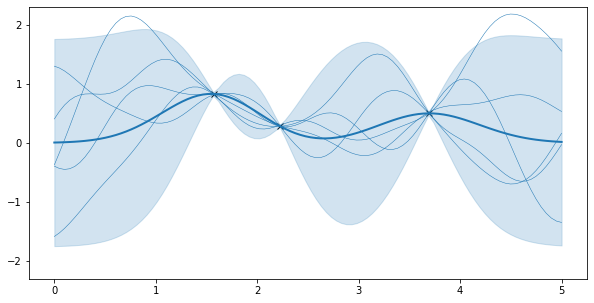

In [12]:
fig = plt.figure(figsize=(10, 5))
camera = Camera(fig)

snap = partial(take_picture, X_query=X_query, data=(X, Y), fig=fig, camera=camera)

elbo_log = []
iterations = 8000
snap(m)
for step in range(iterations):
    optimization_step()
    if step % 10 == 0:
        elbo = -training_loss().numpy()
        elbo_log.append(elbo)
    if step < 1000:
        if step % 100 == 0:
            print(f"ELBO at step {step}: {elbo:.2f}")
    else:
        if step % 1000 == 0:
            print(f"ELBO at step {step}: {elbo:.2f}")
    
    if step % 80 == 0:
        snap(m) # Take picture of the state at every 80 iterations for animating

animation = camera.animate(interval=40, repeat=False)
animation.save("figs/gp_conditioning.gif", dpi=200)